
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic DWTs timeseries

inputs required: 
  * Historical DWTs
  * Historical AWT and IWT
  * Synthetic timeseries of AWT and IWT
  
in this notebook:
  * Fit the ALR model of DWT based on seasonality,and  AWT and IWT timeseries
  * Generate *n* simulations of 1000 years of DWTs timeseries


### Workflow:

<div>
<img src="resources/nb01_11.png" width="400px">
</div>



Simulating sequencing and persistence of synthetic DWTs is accomplished with an autoregressive logistic model (ALR). ALR models are simultaneously able to account for covariates varying at different timescales as well as the autocorrelation of those covariates at different orders (Guanche et al., 2013; Antolinez et al., 2015). In this sense, the AWT, seasonality, IWT, as well as the ordering (transitions between DWTs) and duration (persistence within a DWT) can all be accounted for within a single framework to make a categorical decision of what the weather pattern should be on any given day. Mathematically, the model is represented as:


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Prob$(Y_t=i|Y_{t-1},...,Y_{t-e},X_t)$ = 
 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= {{\exp{\large (}\beta_{0,i} + \beta_{1,i}\cos \omega t + \beta_{2,i}\sin \omega t + \sum\limits_{j=1}^{3}\beta_{j,i}^{awt} APC_j(t) + \sum\limits_{j=1}^{2}\beta_{j,i}^{iwt} IPC_j(t) + \sum\limits_{j=1}^e Y_{t-j\gamma j,i}{\large )}} \over {\sum\limits_{k=1}^{n_{DWT}} \exp{\large (}\beta_{0,k} + \beta_{1,k}\cos \omega t + \beta_{2,k}\sin \omega t + \sum\limits_{j=1}^{3}\beta_{j,k}^{awt} APC_j(t) + \sum\limits_{j=1}^{2}\beta_{j,k}^{iwt} IPC_j(t) + \sum\limits_{j=1}^e Y_{t-j\gamma j,k}{\large )}}}$;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</center>
 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\forall i = 1,...,n_{ss}$
 
where  $\beta_{1,i}$ and $\beta_{2,i}$ covariates account for the seasonal probabilites of each DWT. Covariates $\beta_{j,k}^{awt} APC_j(t)$ account for each weather type’s probability associated with the leading three principle components used to create the AWTs, covariates $\beta_{j,k}^{iwt} IPC_j(t)$ account for the leading two principle components of the MJO, and $Y_{t-j}$ represents the DWT of the previous j-states, and $\beta_{j,i}$  is the parameter associated with the previous j-state, and the order e corresponds to the number of previous states that influence the actual DWT.
Each of these covariates was found to be statistically significant by the likelihood ratio (Guanche et al. 2014), where inclusion of a covariate required an improvement in prediction beyond a penalty associated with the added degrees of freedom. An iterative method began with the best univariate model (seasonality) and added each covariate in a pair-wise fashion to determine the next best model (seasonality + $APC_1$), continuing this process until all covariates were added. 

The model performance is evaluated at the end of the notebook by means of comparison historical and simulated probabilities of occurrence of the 42 DWTs during a perpetual year, the transition probabilities between DWTs and finally seasonal and conditional probabilities of occurrance of DWT to AWT and IWT. 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.alr import ALR_WRP
from teslakit.util.time_operations import xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

MJO_fit = db.Load_MJO_hist()           # historical MJO
KMA_fit = db.Load_ESTELA_KMA()         # ESTELA + TCs Predictor
PCs_all = db.Load_SST_PCA()            # SST PCs (annual)

MJO_sim_all = db.Load_MJO_sim()        # MJO simulations (daily)
PCs_sim_all = db.Load_SST_PCs_sim_d()  # SST PCs simulations (daily)

# ALR fit parameters
alr_num_clusters = 42
alr_markov_order = 3
alr_seasonality = [2, 4]

# ALR simulation
num_sims = 10  # one simulation for each simulated MJO, SST 



## ESTELA Predictor - Autoregressive Logistic Regression Fitting

In [4]:
# --------------------------------------
# Data used to FIT ALR model and preprocess: 

# KMA: bmus (daily) (use sorted_bmus_storms, add 1 to get 1-42 bmus set)
BMUS_fit = xr.Dataset(
    {
        'bmus':(('time',), KMA_fit['sorted_bmus_storms'].values[:] + 1),
    },
    coords = {'time': KMA_fit.time.values[:]}
)


# MJO: rmm1, rmm2 (daily)
print(MJO_fit)

# SST: PCs (annual)
sst_PCs = PCs_all.PCs.values[:]
PCs_fit = xr.Dataset(
    {
        'PC1': (('time',), sst_PCs[:,0]),
        'PC2': (('time',), sst_PCs[:,1]),
        'PC3': (('time',), sst_PCs[:,2]),
    },
    coords = {'time': PCs_all.time.values[:]}
)

# reindex annual data to daily data
PCs_fit = xds_reindex_daily(PCs_fit)
print(PCs_fit)


<xarray.Dataset>
Dimensions:  (time: 15191)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-08-03
Data variables:
    mjo      (time) float64 ...
    phase    (time) int64 ...
    rmm1     (time) float64 ...
    rmm2     (time) float64 ...
<xarray.Dataset>
Dimensions:  (time: 50769)
Coordinates:
  * time     (time) datetime64[ns] 1880-06-01 1880-06-02 ... 2019-06-01
Data variables:
    PC1      (time) float64 4.959 4.959 4.959 4.959 ... 14.3 14.3 14.3 8.241
    PC2      (time) float64 5.007 5.007 5.007 5.007 ... 5.867 5.867 5.867 19.06
    PC3      (time) float64 -5.936 -5.936 -5.936 -5.936 ... -9.966 -9.966 -2.11


In [5]:
# --------------------------------------
# Mount covariates matrix (model fit: BMUS_fit, MJO_fit, PCs_fit)

# covariates_fit dates
d_fit = xds_common_dates_daily([MJO_fit, PCs_fit, BMUS_fit])

# KMA dates
BMUS_fit = BMUS_fit.sel(time = slice(d_fit[0], d_fit[-1]))

# PCs covars 
cov_PCs = PCs_fit.sel(time = slice(d_fit[0], d_fit[-1]))
cov_1 = cov_PCs.PC1.values.reshape(-1,1)
cov_2 = cov_PCs.PC2.values.reshape(-1,1)
cov_3 = cov_PCs.PC3.values.reshape(-1,1)

# MJO covars
cov_MJO = MJO_fit.sel(time = slice(d_fit[0], d_fit[-1]))
cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

# join covars 
cov_T = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))

# normalize
cov_norm_fit = (cov_T - cov_T.mean(axis=0)) / cov_T.std(axis=0)
cov_fit = xr.Dataset(
    {
        'cov_norm': (('time','n_covariates'), cov_norm_fit),
        'cov_names': (('n_covariates',), ['PC1','PC2','PC3','MJO1','MJO2']),
    },
    coords = {'time': d_fit}
)
print(cov_fit)


<xarray.Dataset>
Dimensions:    (n_covariates: 5, time: 14719)
Coordinates:
  * time       (time) datetime64[ns] 1979-02-13 1979-02-14 ... 2019-06-01
Dimensions without coordinates: n_covariates
Data variables:
    cov_norm   (time, n_covariates) float64 -0.2024 0.7182 ... -0.8723 -2.634
    cov_names  (n_covariates) <U4 'PC1' 'PC2' 'PC3' 'MJO1' 'MJO2'


In [6]:
# --------------------------------------
# Autoregressive Logistic Regression

# model fit: BMUS_fit, cov_fit, num_clusters
# model sim: cov_sim, sim_num, sim_years

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (True, alr_seasonality),
    'covariates': (True, cov_fit),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.ESTELA.alrw)
ALRW.SetFitData(alr_num_clusters, BMUS_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)



Fitting autoregressive logistic model ...
Optimization done in 247.67 seconds



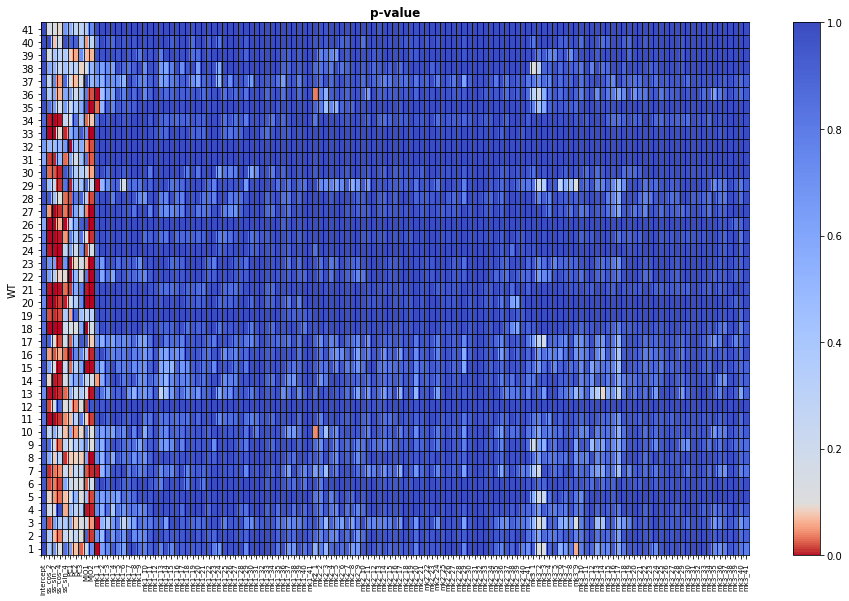

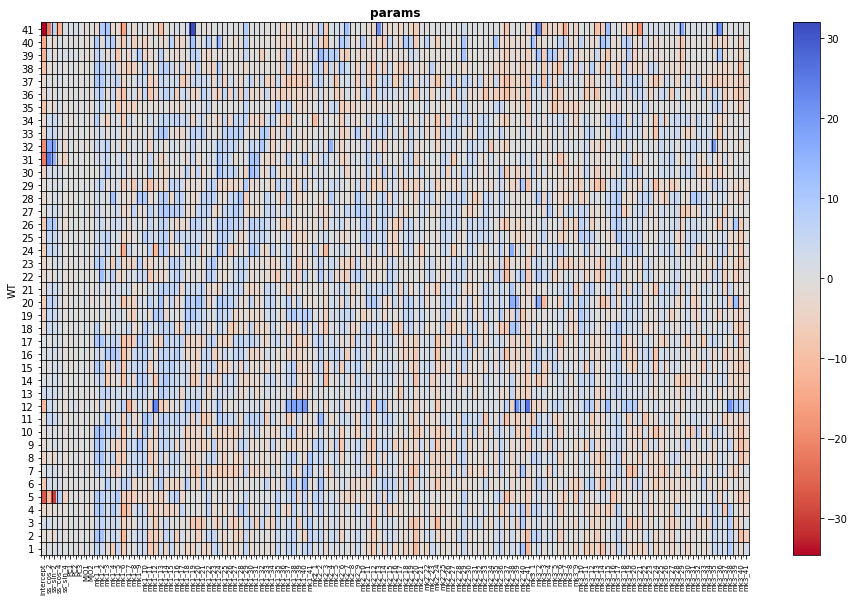

In [7]:
# Plot model p-values and params
ALRW.Report_Fit()



## ESTELA Predictor - Autoregressive Logistic Regression Simulation

In [8]:
# --------------------------------------
# Prepare Covariates for ALR simulations

# simulation dates
d_sim = xds_common_dates_daily([MJO_sim_all, PCs_sim_all])

# join covariates for all MJO, PCs simulations
l_cov_sims = []
for i in MJO_sim_all.n_sim: 

    # select simulation
    MJO_sim = MJO_sim_all.sel(n_sim=i)
    PCs_sim = PCs_sim_all.sel(n_sim=i)

    # PCs covar 
    cov_PCs = PCs_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_1 = cov_PCs.PC1.values.reshape(-1,1)
    cov_2 = cov_PCs.PC2.values.reshape(-1,1)
    cov_3 = cov_PCs.PC3.values.reshape(-1,1)

    # MJO covars
    cov_MJO = MJO_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
    cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

    # join covars (do not normalize simulation covariates)
    cov_T_sim = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))
    cov_sim = xr.Dataset(
        {
            'cov_values': (('time','n_covariates'), cov_T_sim),
        },
        coords = {'time': d_sim}
    )
    l_cov_sims.append(cov_sim)

# use "n_sim" name to join covariates (ALR.Simulate() will recognize it)
cov_sims = xr.concat(l_cov_sims, dim='n_sim')
cov_sims = cov_sims.squeeze()

print(cov_sims)


<xarray.Dataset>
Dimensions:     (n_covariates: 5, n_sim: 100, time: 365244)
Coordinates:
  * time        (time) object 2000-01-01 2000-01-02 ... 2999-12-31 3000-01-01
Dimensions without coordinates: n_covariates, n_sim
Data variables:
    cov_values  (n_sim, time, n_covariates) float32 -21.934853 ... 0.0912332


In [9]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# launch simulation
xds_alr = ALRW.Simulate(num_sims, d_sim, cov_sims, overfit_filter=True)

# Store Daily Weather Types
DWT_sim = xds_alr.evbmus_sims.to_dataset()
db.Save_ESTELA_DWT_sim(DWT_sim)

print(DWT_sim)


ALR model fit   : 1979-02-13 --- 2019-06-01
ALR model sim   : 2000-01-01 --- 3000-01-01

Launching 10 simulations...

Sim. Num. 010 (Covs. 010): 100%|██████████| 365241/365241 [20:52<00:00, 291.52it/s]

overfit filter log
sim. 00 - 2006-02-05 00:00:00 - activated (max prob 0.9874685537052623)
sim. 00 - 2006-02-06 00:00:00 - deactivated (max prob 0.7501205977430264)
sim. 00 - 2006-03-02 00:00:00 - activated (max prob 0.9816479221012178)
sim. 00 - 2006-03-03 00:00:00 - deactivated (max prob 0.3566211089100602)
sim. 00 - 2034-04-09 00:00:00 - activated (max prob 0.9875817703370996)
sim. 00 - 2034-04-10 00:00:00 - deactivated (max prob 0.3725518504821738)
sim. 00 - 2050-01-22 00:00:00 - activated (max prob 0.9802385206322334)
sim. 00 - 2050-01-23 00:00:00 - deactivated (max prob 0.6486440208637259)
sim. 00 - 2052-10-07 00:00:00 - activated (max prob 0.9897472501893885)
sim. 00 - 2052-10-08 00:00:00 - deactivated (max prob 0.39220108221026556)
sim. 00 - 2053-04-19 00:00:00 - activated (max 

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365244)
Coordinates:
  * time         (time) object 2000-01-01 2000-01-02 ... 2999-12-31 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 14 14 14 14 14 14 14 ... 27 20 15 19 19 12
Attributes:
    source:   teslakit_v0.9.1


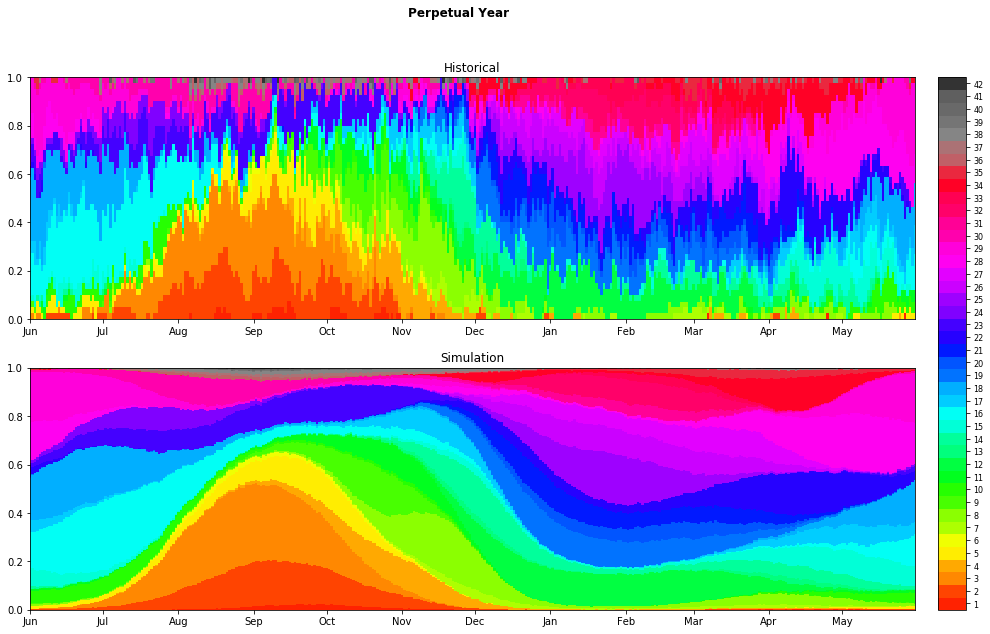

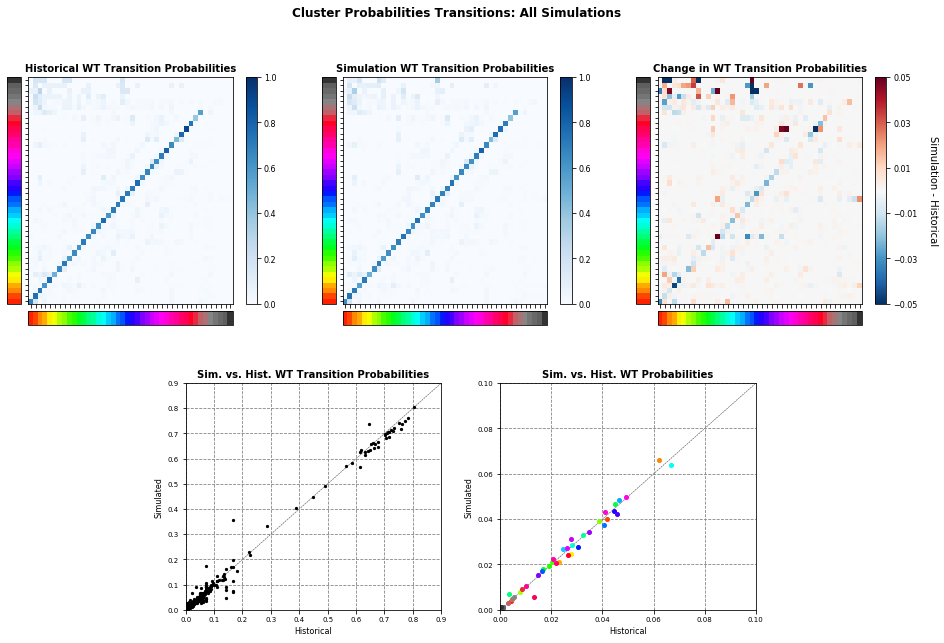

In [10]:
# show sim report
ALRW.Report_Sim(py_month_ini=6, persistences_table=False);


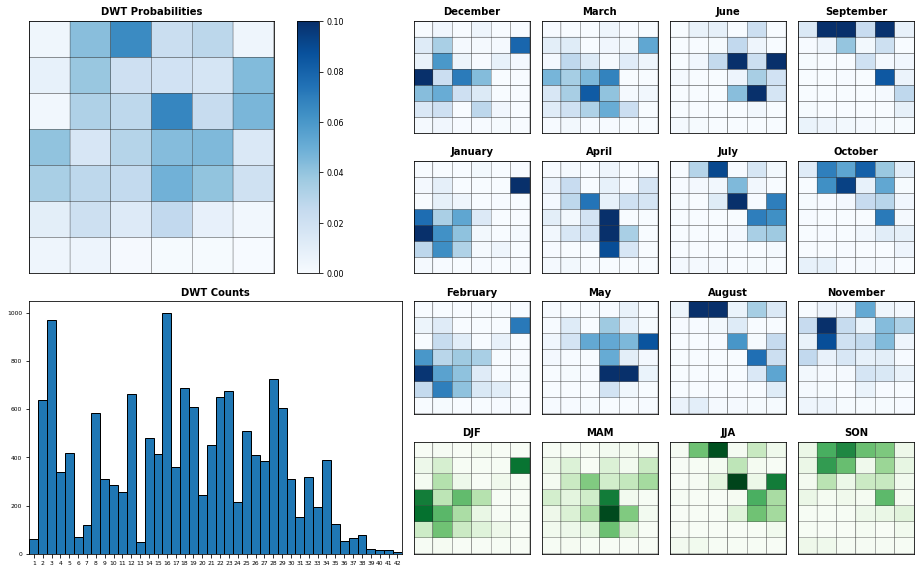

In [11]:
# Plot Historical DWTs probabilities (with TCs DWTs)

bmus_fit = KMA_fit.sorted_bmus_storms.values[:] + 1
dbmus_fit = KMA_fit.time.values[:]

Plot_DWTs_Probs(bmus_fit, dbmus_fit, alr_num_clusters);


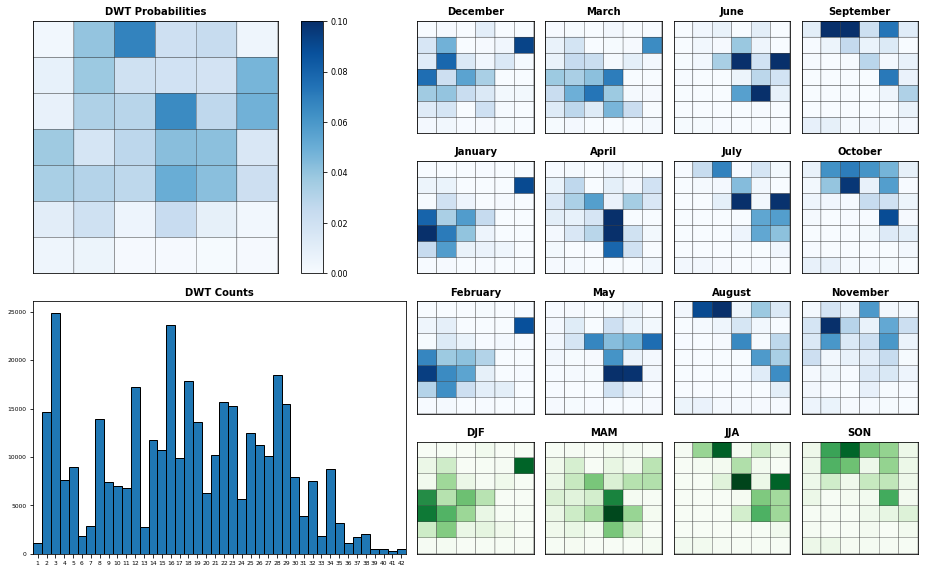

In [12]:
# Plot Simulated DWTs probabilities (with TCs DWTs)

bmus_sim = DWT_sim.isel(n_sim=0).evbmus_sims.values[:]
dbmus_sim = DWT_sim.time.values[:]

Plot_DWTs_Probs(bmus_sim, dbmus_sim, alr_num_clusters);


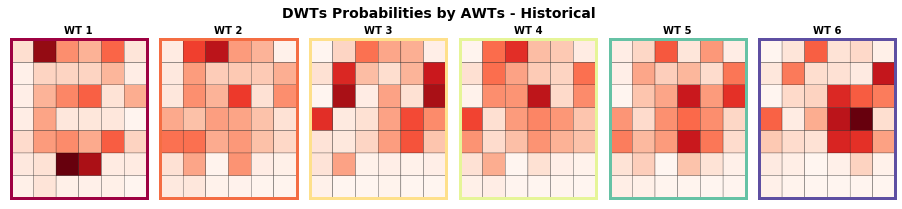

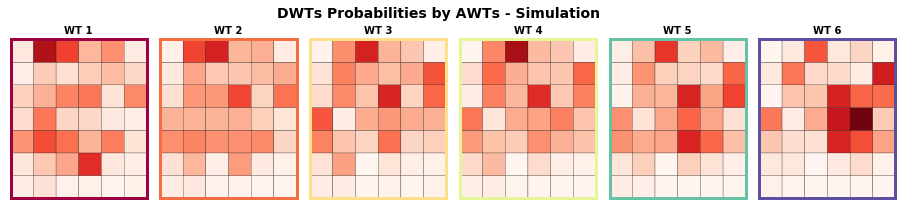

In [13]:
# Plot AWTs/DWTs Probabilities 

# clusters to plot (no TCs)
n_clusters_AWT = 6
n_clusters_DWT = 42
n_sim = 0  # simulation to plot

# Plot AWTs/DWTs Probs - historical
AWT_hist, DWT_hist = db.Load_AWTs_DWTs_Plots_hist()
AWT_bmus = AWT_hist.bmus.values[:]
DWT_bmus = DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Historical'
);

# Plot AWTs/DWTs sim - simulated
AWT_sim, DWT_sim = db.Load_AWTs_DWTs_Plots_sim(n_sim=0)
AWT_bmus = AWT_sim.bmus.values[:]
DWT_bmus = DWT_sim.bmus.values[:]

Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Simulation'
);


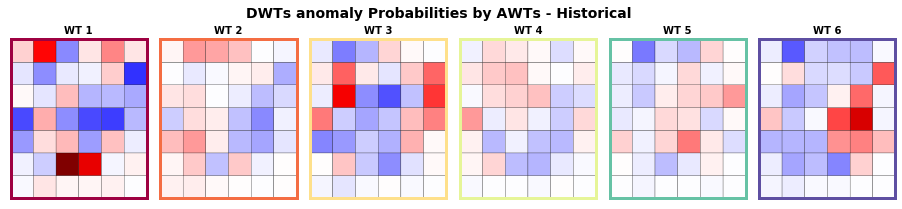

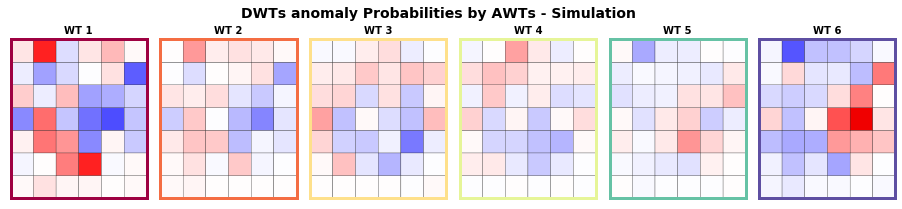

In [14]:
# plot DWTs conditional probabilities to each AWT, minus mean probabilities

# Plot AWTs/DWTs Probs - historical
AWT_hist, DWT_hist = db.Load_AWTs_DWTs_Plots_hist()
AWT_bmus = AWT_hist.bmus.values[:]
DWT_bmus = DWT_hist.bmus.values[:]

Plot_Probs_WT_WT_anomaly(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs anomaly Probabilities by AWTs - Historical'
);

# Plot AWTs/DWTs sim - simulated
AWT_sim, DWT_sim = db.Load_AWTs_DWTs_Plots_sim(n_sim=0)
AWT_bmus = AWT_sim.bmus.values[:]
DWT_bmus = DWT_sim.bmus.values[:]

Plot_Probs_WT_WT_anomaly(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs anomaly Probabilities by AWTs - Simulation'
);
